### Intro to Variational Autoencoders

Bloggpost: https://pyro.ai/examples/vae.html

pytorch MNIST: https://github.com/pytorch/examples/blob/master/vae/main.py#L45

Good tutorial paper: https://arxiv.org/pdf/1606.05908.pdf

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torchvision.utils import save_image

import argparse
import easydict

### Parameters

Set parameters for vae training here

In [2]:
#parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
#parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                        help='batch size (default: 64)')
#args = parser.parse_args()

args = easydict.EasyDict({
    "batch_size": 64,
    "no_cuda": False,
    "epochs":8,
    "log_interval":10
})

use_cuda = not args.no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

device = torch.device("cuda" if use_cuda else "cpu")

### Load data

We use the MNIST dataset containing images of handwritten digits 1-9.

In [3]:
path = '/scratch/jonatank/data'

In [4]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(path, train=True, download=True, 
        transform=transforms.ToTensor()),
        batch_size=args.batch_size, shuffle=True,
        **kwargs)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(path, train=False, download=True, 
        transform=transforms.ToTensor()),
        batch_size=args.batch_size, shuffle=True, 
        **kwargs)

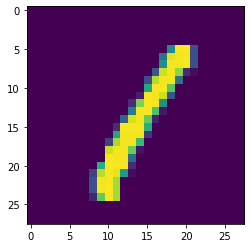

In [5]:
plt.figure()
plt.imshow(train_loader.dataset.data.numpy()[3])

### Define VAE

Below we build up VAE with encoder, decoder. 

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Init model and loss function

In [6]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Train and test functions for training

In [8]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [9]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                #save_image(comparison.cpu(),
                         #'reconstruction/' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


### Training 

Saving images after we learn.

In [10]:
for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            #save_image(sample.view(64, 1, 28, 28),
                       #'results/sample_' + str(epoch) + '.png')

/opt/conda/conda-bld/pytorch_1579162725830/work/torch/csrc/autograd/generated/python_variable_methods.cpp:1334: UserWarning: This overload of add_ is deprecated:
add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
add_(Tensor other, Number alpha)
/opt/conda/conda-bld/pytorch_1579162725830/work/torch/csrc/autograd/generated/python_variable_methods.cpp:1550: UserWarning: This overload of addcmul_ is deprecated:
addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcmul_(Tensor tensor1, Tensor tensor2, Number value)
/opt/conda/conda-bld/pytorch_1579162725830/work/torch/csrc/autograd/generated/python_variable_methods.cpp:1480: UserWarning: This overload of addcdiv_ is deprecated:
addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcdiv_(Tensor tensor1, Tensor tensor2, Number value)


Train Epoch: 1 [0/60000 (0%)]	Loss: 551.309631
Train Epoch: 1 [640/60000 (1%)]	Loss: 299.996490
Train Epoch: 1 [1280/60000 (2%)]	Loss: 230.514633
Train Epoch: 1 [1920/60000 (3%)]	Loss: 212.786179
Train Epoch: 1 [2560/60000 (4%)]	Loss: 223.935303
Train Epoch: 1 [3200/60000 (5%)]	Loss: 210.615112
Train Epoch: 1 [3840/60000 (6%)]	Loss: 200.373581
Train Epoch: 1 [4480/60000 (7%)]	Loss: 193.446976
Train Epoch: 1 [5120/60000 (9%)]	Loss: 204.555710
Train Epoch: 1 [5760/60000 (10%)]	Loss: 194.674881
Train Epoch: 1 [6400/60000 (11%)]	Loss: 176.489700
Train Epoch: 1 [7040/60000 (12%)]	Loss: 174.343323
Train Epoch: 1 [7680/60000 (13%)]	Loss: 172.876404
Train Epoch: 1 [8320/60000 (14%)]	Loss: 177.532242
Train Epoch: 1 [8960/60000 (15%)]	Loss: 168.231674
Train Epoch: 1 [9600/60000 (16%)]	Loss: 175.972824
Train Epoch: 1 [10240/60000 (17%)]	Loss: 170.967667
Train Epoch: 1 [10880/60000 (18%)]	Loss: 172.618484
Train Epoch: 1 [11520/60000 (19%)]	Loss: 160.509949
Train Epoch: 1 [12160/60000 (20%)]	Loss: 

Train Epoch: 2 [40960/60000 (68%)]	Loss: 116.963959
Train Epoch: 2 [41600/60000 (69%)]	Loss: 114.330521
Train Epoch: 2 [42240/60000 (70%)]	Loss: 117.738831
Train Epoch: 2 [42880/60000 (71%)]	Loss: 113.496063
Train Epoch: 2 [43520/60000 (72%)]	Loss: 116.694283
Train Epoch: 2 [44160/60000 (74%)]	Loss: 110.394615
Train Epoch: 2 [44800/60000 (75%)]	Loss: 113.680214
Train Epoch: 2 [45440/60000 (76%)]	Loss: 113.489136
Train Epoch: 2 [46080/60000 (77%)]	Loss: 120.442886
Train Epoch: 2 [46720/60000 (78%)]	Loss: 120.435143
Train Epoch: 2 [47360/60000 (79%)]	Loss: 115.985268
Train Epoch: 2 [48000/60000 (80%)]	Loss: 112.129135
Train Epoch: 2 [48640/60000 (81%)]	Loss: 115.240372
Train Epoch: 2 [49280/60000 (82%)]	Loss: 112.294556
Train Epoch: 2 [49920/60000 (83%)]	Loss: 110.678017
Train Epoch: 2 [50560/60000 (84%)]	Loss: 117.982910
Train Epoch: 2 [51200/60000 (85%)]	Loss: 112.683167
Train Epoch: 2 [51840/60000 (86%)]	Loss: 114.573372
Train Epoch: 2 [52480/60000 (87%)]	Loss: 113.299774
Train Epoch:

Train Epoch: 4 [21760/60000 (36%)]	Loss: 103.579102
Train Epoch: 4 [22400/60000 (37%)]	Loss: 108.015167
Train Epoch: 4 [23040/60000 (38%)]	Loss: 112.398628
Train Epoch: 4 [23680/60000 (39%)]	Loss: 115.541183
Train Epoch: 4 [24320/60000 (41%)]	Loss: 114.492668
Train Epoch: 4 [24960/60000 (42%)]	Loss: 104.599251
Train Epoch: 4 [25600/60000 (43%)]	Loss: 108.062500
Train Epoch: 4 [26240/60000 (44%)]	Loss: 98.838043
Train Epoch: 4 [26880/60000 (45%)]	Loss: 113.139122
Train Epoch: 4 [27520/60000 (46%)]	Loss: 118.918747
Train Epoch: 4 [28160/60000 (47%)]	Loss: 110.023903
Train Epoch: 4 [28800/60000 (48%)]	Loss: 104.847435
Train Epoch: 4 [29440/60000 (49%)]	Loss: 107.614220
Train Epoch: 4 [30080/60000 (50%)]	Loss: 112.924164
Train Epoch: 4 [30720/60000 (51%)]	Loss: 108.356956
Train Epoch: 4 [31360/60000 (52%)]	Loss: 109.741730
Train Epoch: 4 [32000/60000 (53%)]	Loss: 111.587280
Train Epoch: 4 [32640/60000 (54%)]	Loss: 108.225288
Train Epoch: 4 [33280/60000 (55%)]	Loss: 106.356628
Train Epoch: 

Train Epoch: 6 [1280/60000 (2%)]	Loss: 107.917343
Train Epoch: 6 [1920/60000 (3%)]	Loss: 102.672249
Train Epoch: 6 [2560/60000 (4%)]	Loss: 110.801422
Train Epoch: 6 [3200/60000 (5%)]	Loss: 107.955864
Train Epoch: 6 [3840/60000 (6%)]	Loss: 111.475174
Train Epoch: 6 [4480/60000 (7%)]	Loss: 106.111191
Train Epoch: 6 [5120/60000 (9%)]	Loss: 104.172424
Train Epoch: 6 [5760/60000 (10%)]	Loss: 117.381271
Train Epoch: 6 [6400/60000 (11%)]	Loss: 106.280640
Train Epoch: 6 [7040/60000 (12%)]	Loss: 104.585274
Train Epoch: 6 [7680/60000 (13%)]	Loss: 104.583809
Train Epoch: 6 [8320/60000 (14%)]	Loss: 108.716782
Train Epoch: 6 [8960/60000 (15%)]	Loss: 102.319992
Train Epoch: 6 [9600/60000 (16%)]	Loss: 109.022423
Train Epoch: 6 [10240/60000 (17%)]	Loss: 110.366600
Train Epoch: 6 [10880/60000 (18%)]	Loss: 105.246262
Train Epoch: 6 [11520/60000 (19%)]	Loss: 99.136917
Train Epoch: 6 [12160/60000 (20%)]	Loss: 106.014511
Train Epoch: 6 [12800/60000 (21%)]	Loss: 107.495117
Train Epoch: 6 [13440/60000 (22%)]

Train Epoch: 7 [42240/60000 (70%)]	Loss: 105.022324
Train Epoch: 7 [42880/60000 (71%)]	Loss: 106.048279
Train Epoch: 7 [43520/60000 (72%)]	Loss: 115.218277
Train Epoch: 7 [44160/60000 (74%)]	Loss: 104.243210
Train Epoch: 7 [44800/60000 (75%)]	Loss: 101.526810
Train Epoch: 7 [45440/60000 (76%)]	Loss: 113.047859
Train Epoch: 7 [46080/60000 (77%)]	Loss: 104.284782
Train Epoch: 7 [46720/60000 (78%)]	Loss: 108.082153
Train Epoch: 7 [47360/60000 (79%)]	Loss: 112.266960
Train Epoch: 7 [48000/60000 (80%)]	Loss: 103.622665
Train Epoch: 7 [48640/60000 (81%)]	Loss: 105.195671
Train Epoch: 7 [49280/60000 (82%)]	Loss: 107.813377
Train Epoch: 7 [49920/60000 (83%)]	Loss: 108.933807
Train Epoch: 7 [50560/60000 (84%)]	Loss: 102.662292
Train Epoch: 7 [51200/60000 (85%)]	Loss: 107.335938
Train Epoch: 7 [51840/60000 (86%)]	Loss: 101.056137
Train Epoch: 7 [52480/60000 (87%)]	Loss: 104.791428
Train Epoch: 7 [53120/60000 (88%)]	Loss: 108.886902
Train Epoch: 7 [53760/60000 (90%)]	Loss: 104.075554
Train Epoch:

### Plot what we have learned 

By sampleing to the latent feild we can decode the sampeled values and create a "new" number.

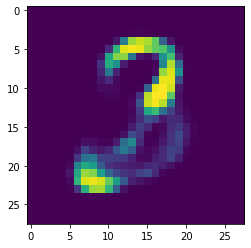

In [11]:
sample = torch.randn(64, 20).to(device)
sample = model.decode(sample).cpu()

plt.imshow(sample.view(64, 1, 28, 28)[0,0].detach().numpy())

## Image reconstruction

Fist we take a image and "remove part of it"

torch.Size([64, 28, 28])

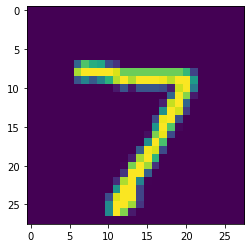

In [12]:
test_img = test_loader.dataset.data[:64].clone()
plt.imshow(test_img[0].numpy())
test_img.size()

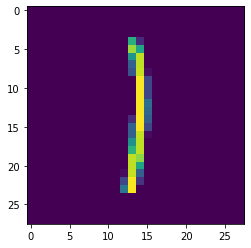

In [13]:
plt.imshow(test_img[40].numpy())

In [14]:
re_test_img = test_img[:,None,:,:].clone().float()

for i in range(args.batch_size):
    rand_idx = torch.randn(2)*10
    #print(rand_idx)
    re_test_img[i,0,int(abs(rand_idx[0])):int(abs(rand_idx[0]))+10, int(abs(rand_idx[1])):int(abs(rand_idx[1]))+10] = 255

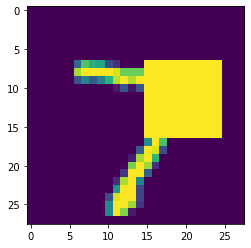

In [15]:
plt.imshow(re_test_img[0,0].numpy())

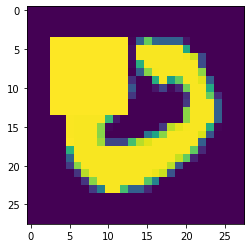

In [16]:
plt.imshow(re_test_img[25,0].numpy())

In [17]:
re_test_img.type()

'torch.FloatTensor'

### Encode image
To get latent representation of this image. 

In [18]:
re_test_loader = torch.utils.data.DataLoader(
        re_test_img,
        batch_size=args.batch_size, shuffle=False, 
        **kwargs)

In [19]:
model.eval()

with torch.no_grad():
    data = re_test_loader.dataset.data.to(device)
    recon_batch, mu, logvar = model(data)

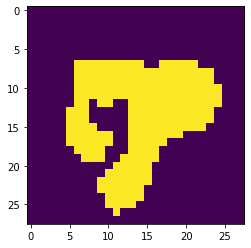

In [20]:
plt.imshow(recon_batch.view(64, 1, 28, 28)[0,0].detach().numpy())

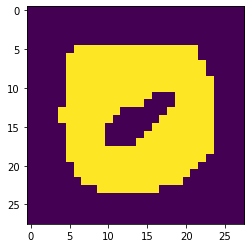

In [21]:
plt.imshow(recon_batch.view(64, 1, 28, 28)[25,0].detach().numpy())

The reconstructed image is relatively good. We try to find the "bad" part of the image by taking abs(reconstructed-original).

### Find bad part

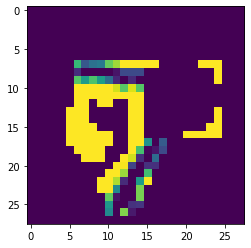

In [22]:
plt.imshow(abs(re_test_img[0,0].numpy()-255*recon_batch.view(64, 1, 28, 28)[0,0].detach().numpy()))

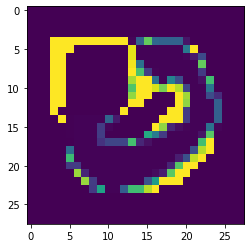

In [23]:
plt.imshow(abs(re_test_img[25,0].numpy()-255*recon_batch.view(64, 1, 28, 28)[25,0].detach().numpy()))

As seen above there are room for improvments.

### Experiments  

In [24]:
re_test_img = test_img[:,None,:,:].clone().float()
re_test_img[:,:,:,:] = 0
re_test_img[0,0,0:5,0:5] = 255

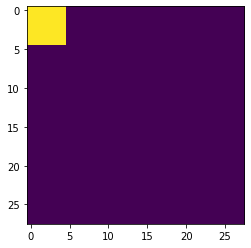

In [25]:
plt.imshow(re_test_img[0,0].numpy())

re_test_loader = torch.utils.data.DataLoader(
        re_test_img,
        batch_size=args.batch_size, shuffle=False, 
        **kwargs)

In [26]:
model.eval()

with torch.no_grad():
    data = re_test_loader.dataset.data.to(device)
    recon_batch, mu, logvar = model(data)

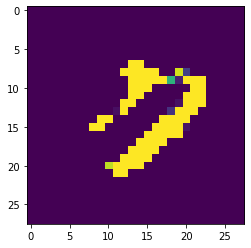

In [27]:
plt.imshow(recon_batch.view(64, 1, 28, 28)[0,0].detach().numpy())